In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
warnings.filterwarnings('ignore')
%matplotlib inline

# 读取数据

In [6]:
def read_data():
    dataset_path = '../data'
    # 读取特征
    features = pd.read_csv(os.path.join(dataset_path, 'features.txt'), sep='\s+', header=None, names=['index', 'feature_name'])
    features = features['feature_name'].values
    for i in range(len(features)):
        features[i] = str(i)+"-"+features[i]

    # 读取活动标签
    activity_labels = pd.read_csv(os.path.join(dataset_path, 'activity_labels.txt'), sep='\s+', header=None, names=['index', 'activity'])

    # 读取训练数据
    X_train = pd.read_csv(os.path.join(dataset_path, 'train', 'X_train.txt'), delim_whitespace=True, header=None, names=features)
    Y_train = pd.read_csv(os.path.join(dataset_path, 'train', 'y_train.txt'), sep=' ', header=None, names=['activity'])
    subject_train = pd.read_csv(os.path.join(dataset_path, 'train', 'subject_train.txt'), header=None, names=['subject'])
    train_data = pd.concat([subject_train, Y_train, X_train], axis=1)
    train_data['activity'] = train_data['activity'].map(activity_labels.set_index('index')['activity'])

    # 读取测试数据
    X_test = pd.read_csv(os.path.join(dataset_path, 'test', 'X_test.txt'), delim_whitespace=True, header=None, names=features)
    Y_test = pd.read_csv(os.path.join(dataset_path, 'test', 'y_test.txt'), sep=' ', header=None, names=['activity'])
    subject_test = pd.read_csv(os.path.join(dataset_path, 'test', 'subject_test.txt'), header=None, names=['subject'])
    test_data = pd.concat([subject_test, Y_test, X_test], axis=1)
    test_data['activity'] = test_data['activity'].map(activity_labels.set_index('index')['activity'])

    # 合并训练和测试数据
    all_data = pd.concat([train_data, test_data], axis=0)
    all_data['activity'] = all_data['activity'].map(activity_labels.set_index('index')['activity'])

    print(f"Null counts in data: {all_data.isnull().sum().sum()}")
    num2label = {
    1: 'WALKING', 
    2: 'WALKING_UPSTAIRS', 
    3: 'WALKING_DOWNSTAIRS', 
    4: 'SITTING', 
    5: 'STANDING', 
    6: 'LAYING'
    }
    label2num = {v: k for k, v in num2label.items()}



    return train_data, test_data, all_data, num2label, label2num

train, test, all_data, num2label, label2num = read_data()

X_train = train.drop(['subject', 'activity'], axis=1)
y_train = train['activity'].map(label2num)
X_test = test.drop(['subject', 'activity'], axis=1)
y_test = test['activity'].map(label2num)

Null counts in data: 10299


In [56]:
train.head()

,subject,activity,0-tBodyAcc-mean()-X,1-tBodyAcc-mean()-Y,2-tBodyAcc-mean()-Z,3-tBodyAcc-std()-X,4-tBodyAcc-std()-Y,5-tBodyAcc-std()-Z,6-tBodyAcc-mad()-X,7-tBodyAcc-mad()-Y,...,551-fBodyBodyGyroJerkMag-meanFreq(),552-fBodyBodyGyroJerkMag-skewness(),553-fBodyBodyGyroJerkMag-kurtosis(),"554-angle(tBodyAccMean,gravity)","555-angle(tBodyAccJerkMean),gravityMean)","556-angle(tBodyGyroMean,gravityMean)","557-angle(tBodyGyroJerkMean,gravityMean)","558-angle(X,gravityMean)","559-angle(Y,gravityMean)","560-angle(Z,gravityMean)"
0,1,STANDING,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,1,STANDING,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,1,STANDING,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,1,STANDING,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,1,STANDING,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892


In [5]:
train.shape, test.shape

((7352, 563), (2947, 563))

# 数据清洗

#### 1. 检查重复值

In [35]:
print('No of duplicates in train: {}'.format(sum(train.duplicated())))
print('No of duplicates in test : {}'.format(sum(test.duplicated())))

No of duplicates in train: 0
No of duplicates in test : 0


#### 2. 检查缺失值

In [36]:
print('We have {} NaN/Null values in train'.format(train.isnull().values.sum()))
print('We have {} NaN/Null values in test'.format(test.isnull().values.sum()))

We have 0 NaN/Null values in train
We have 0 NaN/Null values in test


#### 3. 检查数据不平衡性

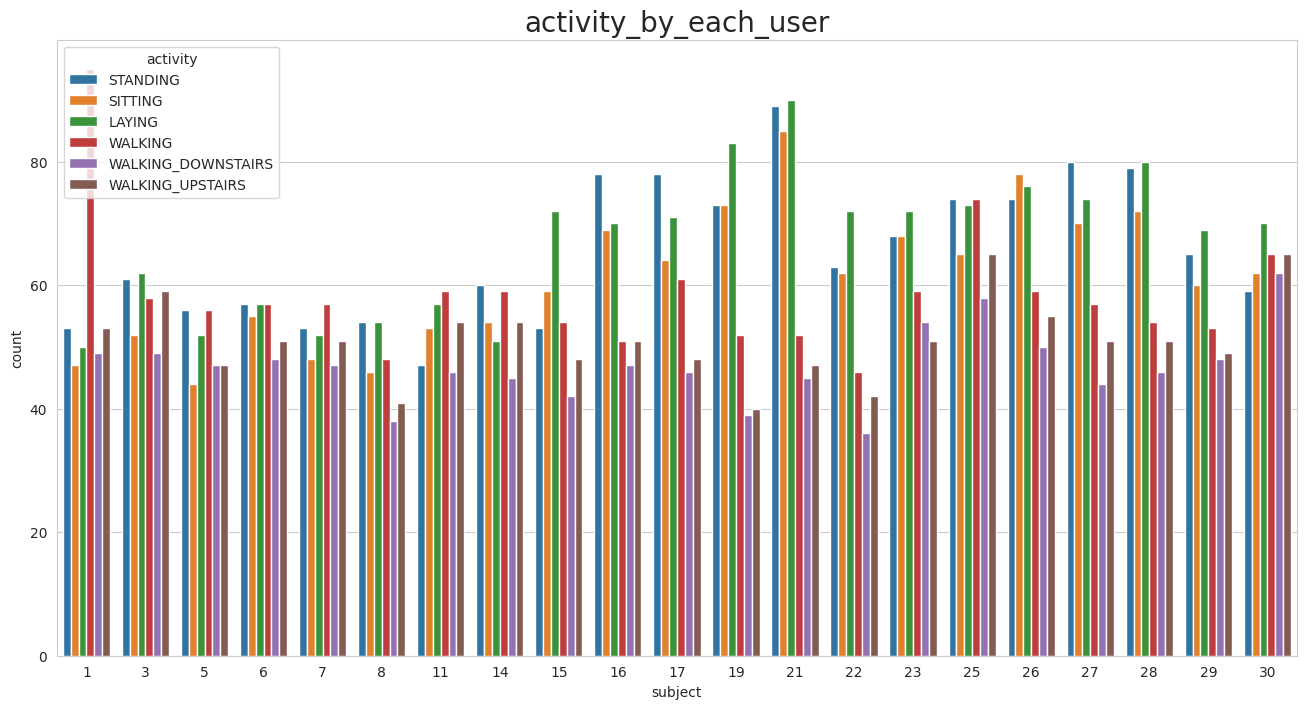

In [37]:
sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'Dejavu Sans'

plt.figure(figsize=(16,8))
plt.title('activity_by_each_user', fontsize=20)
sns.countplot(x='subject', hue='activity', data = train)
plt.savefig('../result/EDA/activity_by_each_user.png', transparent=True)
plt.show()

不同被试的动作没有显著的差异

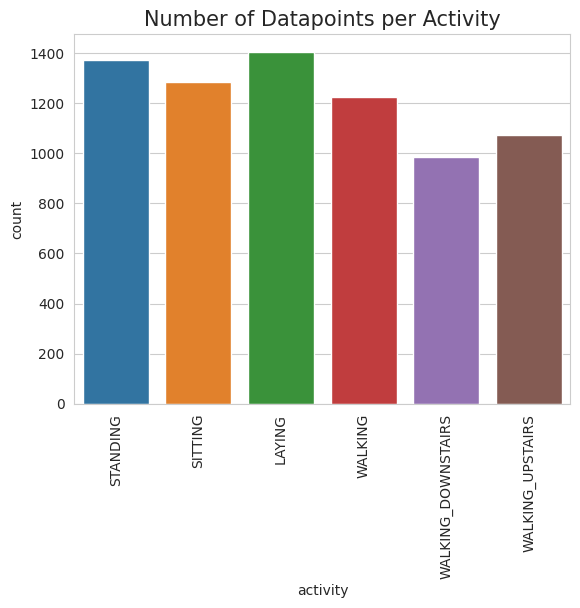

In [ ]:
plt.title('Number of Datapoints per Activity', fontsize=15)
sns.countplot(x="activity", data=train)
plt.xticks(rotation=90)
plt.savefig('../result/EDA/Number_of_Datapoints_per_Activity.png', transparent=True)
plt.show()

数据基本是平衡的

#### 4. 更改列名

去掉括号和逗号

In [59]:
import re

def renew_col_name(column_name):
    
    return re.sub(r'[\d\-\(\),]', '', column_name)

# 使用 rename 方法和上面的函数来修改列名
train.rename(columns=lambda x: renew_col_name(x), inplace=True)
test.rename(columns=lambda x: renew_col_name(x), inplace=True)

train.columns

Index(['subject', 'activity', 'tBodyAccmeanX', 'tBodyAccmeanY',
       'tBodyAccmeanZ', 'tBodyAccstdX', 'tBodyAccstdY', 'tBodyAccstdZ',
       'tBodyAccmadX', 'tBodyAccmadY',
       ...
       'fBodyBodyGyroJerkMagmeanFreq', 'fBodyBodyGyroJerkMagskewness',
       'fBodyBodyGyroJerkMagkurtosis', 'angletBodyAccMeangravity',
       'angletBodyAccJerkMeangravityMean', 'angletBodyGyroMeangravityMean',
       'angletBodyGyroJerkMeangravityMean', 'angleXgravityMean',
       'angleYgravityMean', 'angleZgravityMean'],
      dtype='object', length=563)

In [60]:
train.columns[train.columns.duplicated()][:10]

Index(['tBodyAccarCoeffX', 'tBodyAccarCoeffX', 'tBodyAccarCoeffX',
       'tBodyAccarCoeffY', 'tBodyAccarCoeffY', 'tBodyAccarCoeffY',
       'tBodyAccarCoeffZ', 'tBodyAccarCoeffZ', 'tBodyAccarCoeffZ',
       'tGravityAccarCoeffX'],
      dtype='object')

有很多重复的列名

#### 5. 保存数据

In [62]:
train.to_csv('../data/f_train.csv', index=False)
test.to_csv('../data/f_test.csv', index=False)

# EDA

#### 0. 相关性热力图

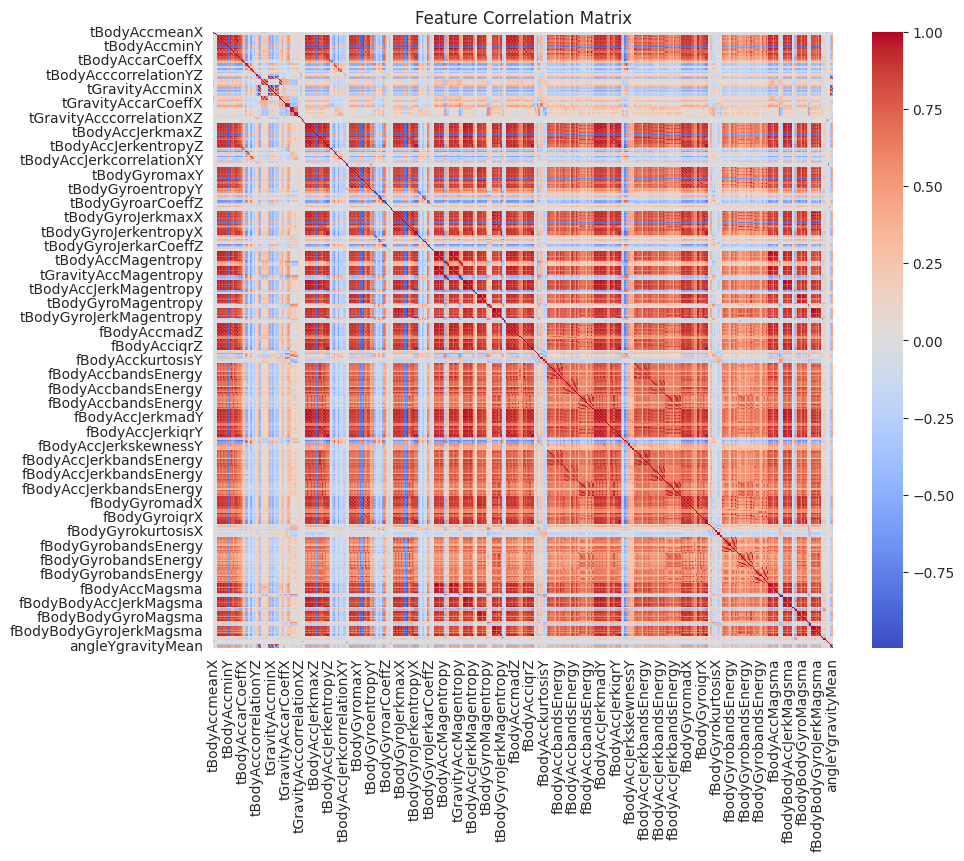

In [99]:
X_train = train.drop(['subject', 'activity'], axis=1)
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr(), cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.savefig('../result/EDA/Feature_Correlation_Matrix.png', transparent=True)
plt.show()

#### 1. Featuring Engineering from Domain Knowledge

- 在静态动作中（sit, stand, lie down）动态特征用处不大
- 在动态动作中（walking, walkingupstairs, walkingdownstairs）动态特征很重要

#### 2. 静态动作和动态动作

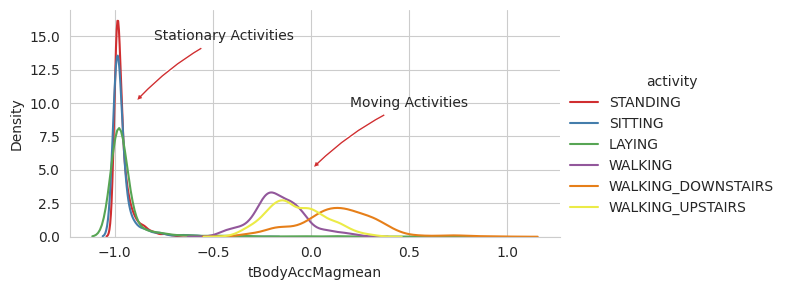

In [89]:
sns.set_palette("Set1", desat=0.80)
facetgrid = sns.FacetGrid(train, hue='activity', aspect=2)
facetgrid.map(sns.kdeplot, 'tBodyAccMagmean', fill=False).add_legend()

facetgrid.ax.annotate("Stationary Activities", xy=(-0.9, 10), xytext=(-0.8, 15), size=10,
                      va='center', ha='left',
                      arrowprops=dict(arrowstyle="simple", connectionstyle="arc3,rad=0.1"))

facetgrid.ax.annotate("Moving Activities", xy=(0, 5), xytext=(0.2, 10), size=10,
                      va='center', ha='left',
                      arrowprops=dict(arrowstyle="simple", connectionstyle="arc3,rad=0.1"))

plt.savefig('../result/EDA/Stationary_vs_Moving_Activities.png', transparent=True)
plt.show()

以动态特征tBodyAccMagmean为例，可以看出动态动作的值显著高一些，而静态特征都在-1附近

In [77]:
num2label

{1: 'WALKING',
 2: 'WALKING_UPSTAIRS',
 3: 'WALKING_DOWNSTAIRS',
 4: 'SITTING',
 5: 'STANDING',
 6: 'LAYING'}

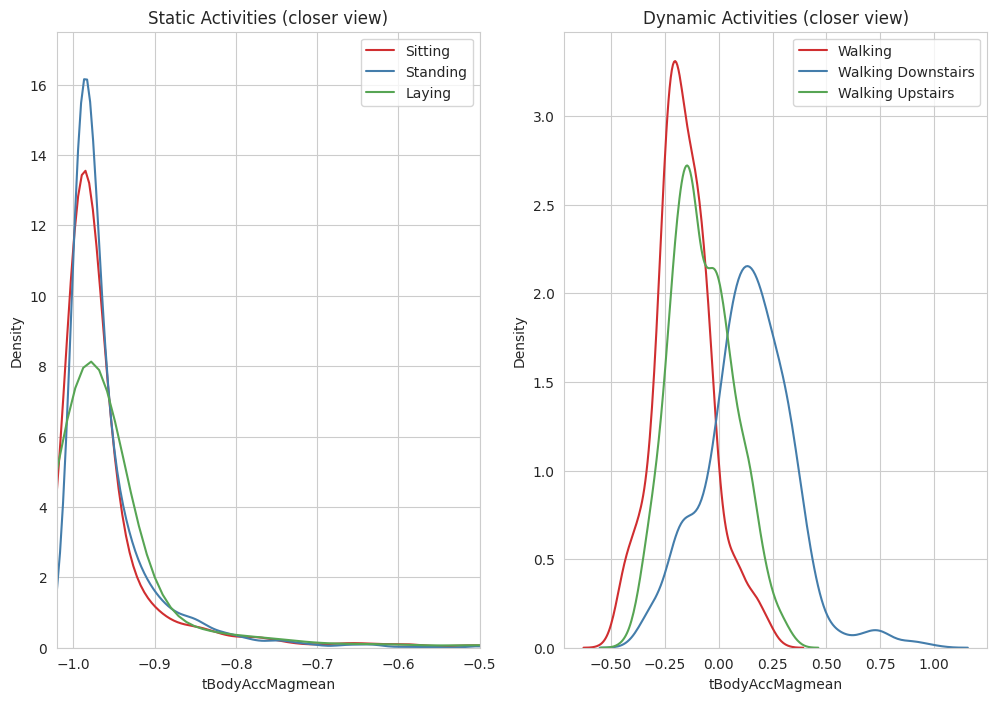

In [91]:
from pickle import FALSE


df1 = train[train['activity']=='WALKING']
df2 = train[train['activity']=='WALKING_UPSTAIRS']
df3 = train[train['activity']=='WALKING_DOWNSTAIRS']
df4 = train[train['activity']=='SITTING']
df5 = train[train['activity']=='SIANDING']
df6 = train[train['activity']=='LAYING']

plt.figure(figsize=(12,8))

# 静态活动
plt.subplot(1,2,1)
plt.title("Static Activities (closer view)")
sns.kdeplot(train[train["activity"]=="SITTING"]['tBodyAccMagmean'], label='Sitting', fill=False)
sns.kdeplot(train[train["activity"]=="STANDING"]['tBodyAccMagmean'], label='Standing', fill=False)
sns.kdeplot(train[train["activity"]=="LAYING"]['tBodyAccMagmean'], label='Laying', fill=False)
plt.axis([-1.02, -0.5, 0, 17.5])
plt.legend()

# 动态活动
plt.subplot(1,2,2)
plt.title("Dynamic Activities (closer view)")
sns.kdeplot(train[train["activity"]=="WALKING"]['tBodyAccMagmean'], label='Walking', fill=False)
sns.kdeplot(train[train["activity"]=="WALKING_DOWNSTAIRS"]['tBodyAccMagmean'], label='Walking Downstairs', fill=False)
sns.kdeplot(train[train["activity"]=="WALKING_UPSTAIRS"]['tBodyAccMagmean'], label='Walking Upstairs', fill=False)
plt.legend()

plt.savefig('../result/EDA/Static_vs_Dynamic_Activities.png', transparent=True)
plt.show()

#### 3. 加速度的尺度

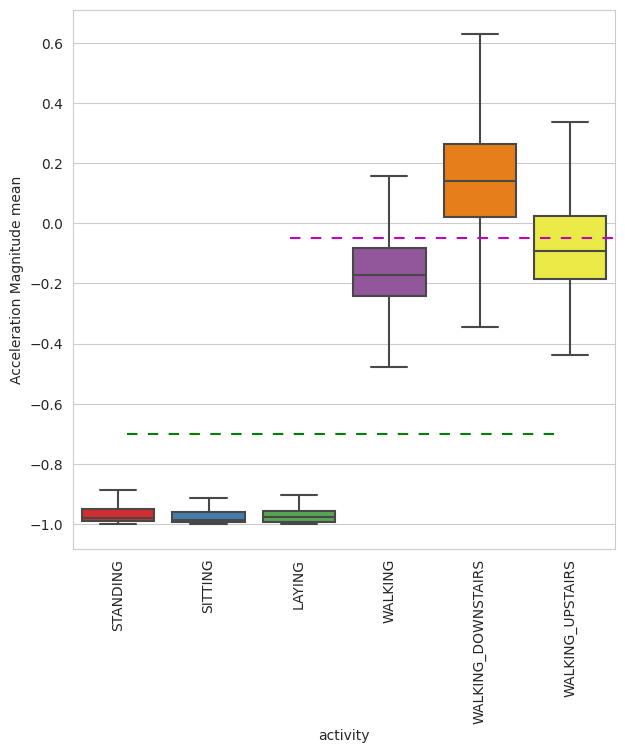

In [94]:
plt.figure(figsize=(7,7))
sns.boxplot(x='activity', y='tBodyAccMagmean',data=train, showfliers=False, saturation=1)
plt.ylabel('Acceleration Magnitude mean')
plt.axhline(y=-0.7, xmin=0.1, xmax=0.9,dashes=(5,5), c='g')
plt.axhline(y=-0.05, xmin=0.4, dashes=(5,5), c='m')
plt.xticks(rotation=90)
plt.savefig('../result/EDA/Acceleration_Magnitude_mean_by_Activity.png', transparent=True)
plt.show()

- 如果tAccMean小于-0.8，则动作是静态的
- 如果tAccMean大于-0.6，则动作是动态的
- 如果tAccMean大于0.0，则动作是walkingdownstairs
- 基本上可以根据这一准则分类75%的动作

#### 4. GravityAccelerationComponants也很重要

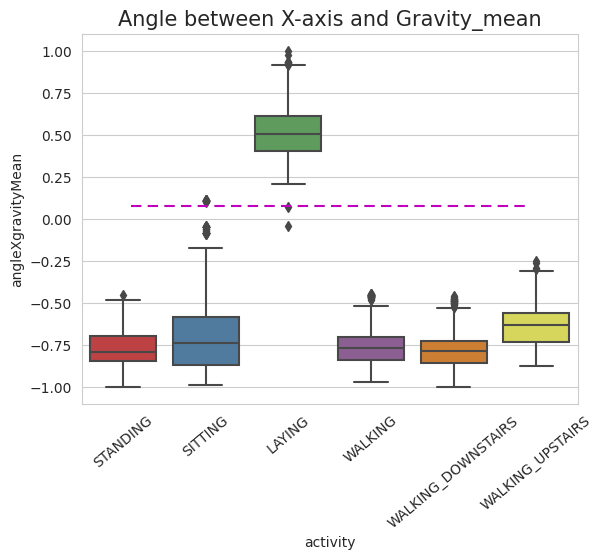

In [96]:
sns.boxplot(x='activity', y='angleXgravityMean', data=train)
plt.axhline(y=0.08, xmin=0.1, xmax=0.9,c='m',dashes=(5,3))
plt.title('Angle between X-axis and Gravity_mean', fontsize=15)
plt.xticks(rotation = 40)
plt.savefig('../result/EDA/Angle_between_X-axis_and_Gravity_mean.png', transparent=True)
plt.show()

- 如果angleXgravityMean大于0，则动作是laying

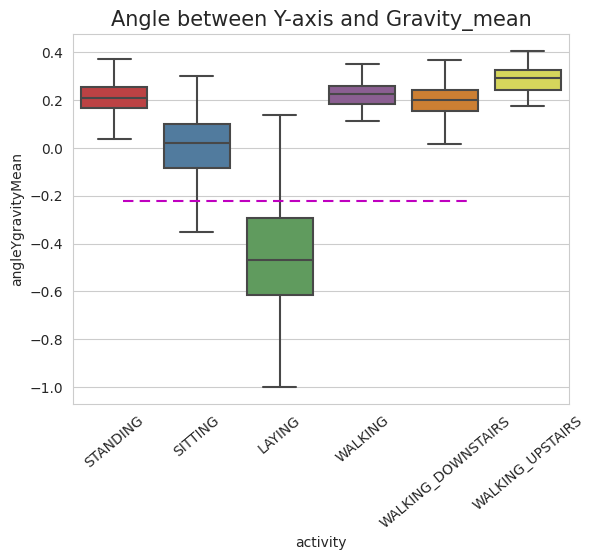

In [97]:
sns.boxplot(x='activity', y='angleYgravityMean', data = train, showfliers=False)
plt.title('Angle between Y-axis and Gravity_mean', fontsize=15)
plt.xticks(rotation = 40)
plt.axhline(y=-0.22, xmin=0.1, xmax=0.8, dashes=(5,3), c='m')
plt.savefig('../result/EDA/Angle_between_Y-axis_and_Gravity_mean.png', transparent=True)
plt.show()

# 应用t-sne

In [106]:
from sklearn.manifold import TSNE
def perform_tsne(X_data, y_data, perplexities, n_iter=1000, img_name_prefix='t-sne'):
    for index, perplexity in enumerate(perplexities):
        # perform t-sne
        print('\nperforming tsne with perplexity {} and with {} iterations at max'.format(perplexity, n_iter))
        X_reduced = TSNE(verbose=2, perplexity=perplexity).fit_transform(X_data)
        print('Done..')
        
        # prepare the data for seaborn         
        print('Creating plot for this t-sne visualization..')
        df = pd.DataFrame({'x':X_reduced[:,0], 'y':X_reduced[:,1] ,'label':y_data})
        
        # draw the plot in appropriate place in the grid
        sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, \
                   palette="Set1", markers=['^','v','s','o', '1','2'])
        plt.title("perplexity : {} and max_iter : {}".format(perplexity, n_iter))
        img_name = img_name_prefix + '_perp_{}_iter_{}.png'.format(perplexity, n_iter)
        print('saving this plot as image in present working directory...')
        plt.savefig(os.path.join('../result/EDA/', img_name), transparent=True)
        plt.show()
        print('Done')


performing tsne with perplexity 5 and with 1000 iterations at max
[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 7352 samples in 0.011s...
[t-SNE] Computed neighbors for 7352 samples in 0.640s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7352
[t-SNE] Computed conditional probabilities for sample 2000 / 7352
[t-SNE] Computed conditional probabilities for sample 3000 / 7352
[t-SNE] Computed conditional probabilities for sample 4000 / 7352
[t-SNE] Computed conditional probabilities for sample 5000 / 7352
[t-SNE] Computed conditional probabilities for sample 6000 / 7352
[t-SNE] Computed conditional probabilities for sample 7000 / 7352
[t-SNE] Computed conditional probabilities for sample 7352 / 7352
[t-SNE] Mean sigma: 0.961446
[t-SNE] Computed conditional probabilities in 0.031s
[t-SNE] Iteration 50: error = 107.1714325, gradient norm = 0.0377430 (50 iterations in 0.570s)
[t-SNE] Iteration 100: error = 95.6812363, gradient norm = 0.0131836 (50 iterations in 

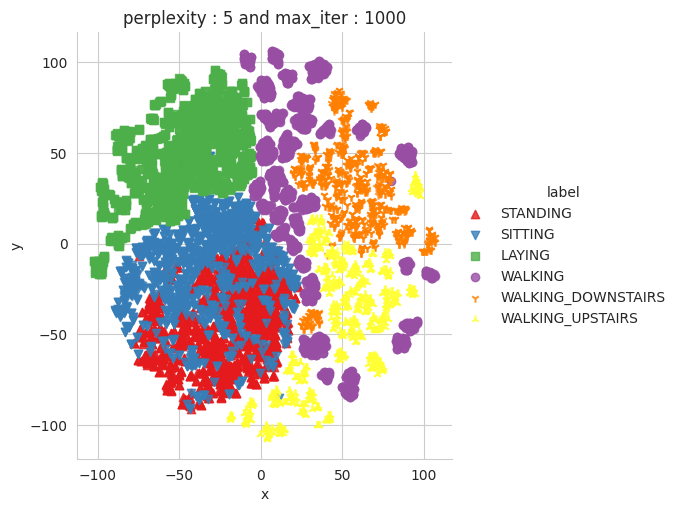

Done

performing tsne with perplexity 10 and with 1000 iterations at max
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 7352 samples in 0.010s...
[t-SNE] Computed neighbors for 7352 samples in 0.679s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7352
[t-SNE] Computed conditional probabilities for sample 2000 / 7352
[t-SNE] Computed conditional probabilities for sample 3000 / 7352
[t-SNE] Computed conditional probabilities for sample 4000 / 7352
[t-SNE] Computed conditional probabilities for sample 5000 / 7352
[t-SNE] Computed conditional probabilities for sample 6000 / 7352
[t-SNE] Computed conditional probabilities for sample 7000 / 7352
[t-SNE] Computed conditional probabilities for sample 7352 / 7352
[t-SNE] Mean sigma: 1.133827
[t-SNE] Computed conditional probabilities in 0.060s
[t-SNE] Iteration 50: error = 97.8991470, gradient norm = 0.0353623 (50 iterations in 0.655s)
[t-SNE] Iteration 100: error = 88.9407349, gradient norm = 0.0107624 (50 iteration

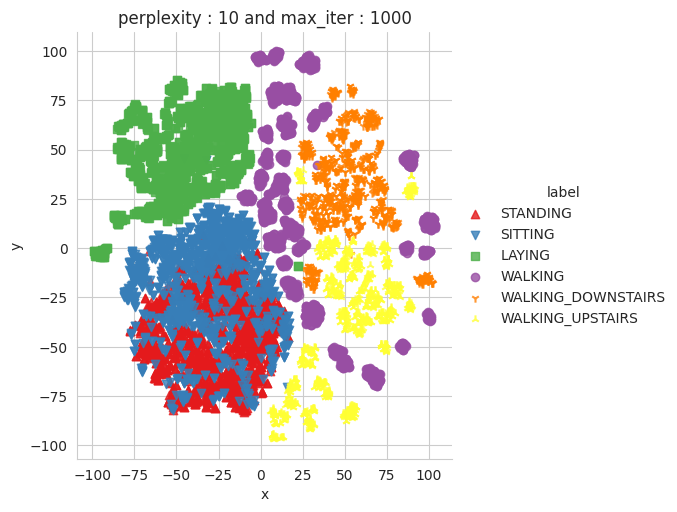

Done

performing tsne with perplexity 20 and with 1000 iterations at max
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 7352 samples in 0.011s...
[t-SNE] Computed neighbors for 7352 samples in 0.695s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7352
[t-SNE] Computed conditional probabilities for sample 2000 / 7352
[t-SNE] Computed conditional probabilities for sample 3000 / 7352
[t-SNE] Computed conditional probabilities for sample 4000 / 7352
[t-SNE] Computed conditional probabilities for sample 5000 / 7352
[t-SNE] Computed conditional probabilities for sample 6000 / 7352
[t-SNE] Computed conditional probabilities for sample 7000 / 7352
[t-SNE] Computed conditional probabilities for sample 7352 / 7352
[t-SNE] Mean sigma: 1.274336
[t-SNE] Computed conditional probabilities in 0.109s
[t-SNE] Iteration 50: error = 89.3072281, gradient norm = 0.0293277 (50 iterations in 0.767s)
[t-SNE] Iteration 100: error = 82.9614029, gradient norm = 0.0077580 (50 iteration

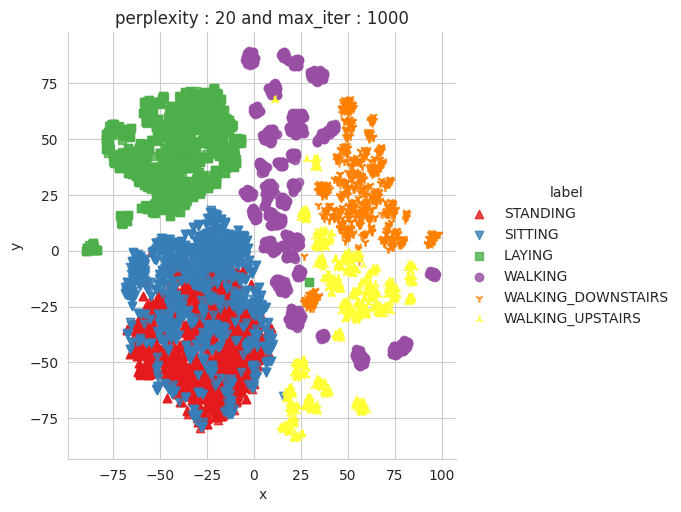

Done


In [107]:
X_pre_tsne = train.drop(['subject', 'activity'], axis=1)
y_pre_tsne = train['activity']
perform_tsne(X_data = X_pre_tsne,y_data=y_pre_tsne, perplexities =[5,10,20])

结论：
- 除了standing和sitting，其它的动作都比较好区分
- 模型可能在这两个变量上表现欠佳

# 应用PCA

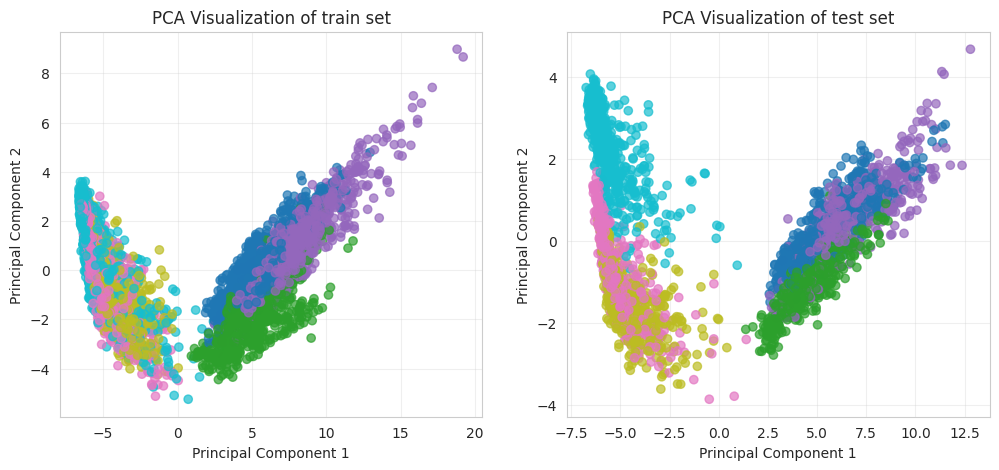

In [122]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# 训练集
data_pca = pca.fit_transform(X_train)
axes[0].scatter(data_pca[:, 0], data_pca[:, 1], c=y_train, cmap='tab10', alpha=0.7)
axes[0].set_title("PCA Visualization of train set")
axes[0].set_xlabel("Principal Component 1")
axes[0].set_ylabel("Principal Component 2")
axes[0].grid(alpha=0.3)

# 测试集
data_pca = pca.fit_transform(X_test)
axes[1].scatter(data_pca[:, 0], data_pca[:, 1], c=y_test, cmap='tab10', alpha=0.7)
axes[1].set_title("PCA Visualization of test set")
axes[1].set_xlabel("Principal Component 1")
axes[1].set_ylabel("Principal Component 2")
axes[1].grid(alpha=0.3)
plt.savefig('../result/EDA/PCA_Visualization.png', transparent=True)
plt.show()

# 聚类趋势（Hopkins Statistic）

In [7]:
from sklearn.neighbors import NearestNeighbors

def hopkins(X, sample_size=100):
    X = X_train.values
    sample_size = 100
    n_samples, n_features = X.shape
    random_indices = np.random.choice(n_samples, sample_size, replace=False)
    sample_points = X[random_indices]

    min_vals = np.min(X, axis=0)
    max_vals = np.max(X, axis=0)
    random_points = np.random.uniform(min_vals, max_vals, (sample_size, n_features))
    nbrs = NearestNeighbors(n_neighbors=2).fit(X)
    u_distances = nbrs.kneighbors(random_points)[0][:, 0]
    w_distances = nbrs.kneighbors(sample_points)[0][:, 1]
    H = np.sum(u_distances) / (np.sum(w_distances) + np.sum(u_distances))
    return H

print(f'train set hopkins statistic: {hopkins(X_train)}')
print(f'test set hopkins statistic: {hopkins(X_test)}')

train set hopkins statistic: 0.8501242783223117
test set hopkins statistic: 0.853751859120193


结论
- H接近1，说明数据具有强聚类趋势

# 5. 聚类模型

## 5.1 k-means

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score, silhouette_score, calinski_harabasz_score, davies_bouldin_score
n_clusters = 6
n_components = .95
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=n_components)),
    ('kmeans', KMeans(n_clusters=n_clusters, random_state=42))
])
labels = pipeline.fit_predict(X_train)
print('dimension after pca:',  pipeline['pca'].n_components_)
true_labels = y_train.iloc[:, 0]

# 内在指标
print('Internal Indices')
# 紧凑度
compactness = compute_compactness(X_train, labels)
print(f'compactness:{compactness: .3f}')

# 分离度
separation = compute_separation(X_train, labels)
print(f'separation:{separation: .3f}')

# 衡量簇内点的紧密度与簇间点的分离度，取值范围：[-1, 1]，值越接近 1，说明聚类效果越好。
SC = silhouette_score(X_train, labels)  
print(f'Silhouette Coefficient:{SC: .3f}')

# 衡量簇间方差和簇内方差的比值，值越大，说明簇间分离度大，簇内紧密度高。
CH = calinski_harabasz_score(X_train, labels)  
print(f'Calinski-Harabasz Index:{CH: .3f}')

# 衡量簇间距离和簇内距离的比值，值越小，说明聚类效果越好
DB = davies_bouldin_score(X_train, labels) 
print(f'Davies-Bouldin Index:{DB: .3f}\n')


# 外在指标
print('External Indices:')
# 取值范围：[-1, 1]，值越接近 1，说明聚类结果与真实标签一致性越高。
ARI = adjusted_rand_score(true_labels, labels) 
print(f'Adjusted Rand Index:{ARI: .3f}')

#取值范围：[0, 1]，值越高说明聚类结果与真实标签一致性越高。
MI = normalized_mutual_info_score(true_labels, labels) 
print(f'Mutual Information:{MI: .3f}')

#取值范围：[0, 1]，值越高说明聚类结果与真实标签一致性越高。
FMI = fowlkes_mallows_score(true_labels, labels)
print(f'FMI:{FMI: .3f}')

c:\Users\62687\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\62687\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=29.
  warnings.warn(


dimension after pca: 102
Internal Indices
compactness: 30402.064
separation: 3.672
Silhouette Coefficient: 0.146
Calinski-Harabasz Index: 3055.201
Davies-Bouldin Index: 2.152

External Indices:
Adjusted Rand Index: 0.424
Mutual Information: 0.560
FMI: 0.532


## 5.3 层次聚类

层次聚类需要计算簇之间的距离，以下是常见的距离度量方法：

- 单链接（Single Linkage）：两个簇中最近点之间的距离。
- 完全链接（Complete Linkage）：两个簇中最远点之间的距离。
- 平均链接（Average Linkage）：两个簇中所有点对之间距离的平均值。
- Ward’s 方法：通过最小化簇内平方误差（within-cluster variance）来合并簇。

### 5.3.1 聚合型层次聚类（Agglomerative Hierarchical Clustering）

- 原理：从每个数据点作为单独的簇开始，不断合并最近的簇，直到所有数据点合并为一个簇，形成层次结构。
- 优点：
简单直观，适用于小数据集。
- 缺点：
难以处理大规模数据集，计算复杂度较高。

In [22]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score, silhouette_score, calinski_harabasz_score, davies_bouldin_score
model = AgglomerativeClustering(n_clusters=6, linkage='ward') #采用ward's方法计算簇间距离
labels = model.fit_predict(X_train)
true_labels = y_train.iloc[:, 0]
# 内在指标
print('Internal Indices')
# 紧凑度
compactness = compute_compactness(X_train, labels)
print(f'compactness:{compactness: .3f}')

# 分离度
separation = compute_separation(X_train, labels)
print(f'separation:{separation: .3f}')

# 衡量簇内点的紧密度与簇间点的分离度，取值范围：[-1, 1]，值越接近 1，说明聚类效果越好。
SC = silhouette_score(X_train, labels)  
print(f'Silhouette Coefficient:{SC: .3f}')

# 衡量簇间方差和簇内方差的比值，值越大，说明簇间分离度大，簇内紧密度高。
CH = calinski_harabasz_score(X_train, labels)  
print(f'Calinski-Harabasz Index:{CH: .3f}')

# 衡量簇间距离和簇内距离的比值，值越小，说明聚类效果越好
DB = davies_bouldin_score(X_train, labels) 
print(f'Davies-Bouldin Index:{DB: .3f}\n')


# 外在指标
print('External Indices:')
# 取值范围：[-1, 1]，值越接近 1，说明聚类结果与真实标签一致性越高。
ARI = adjusted_rand_score(true_labels, labels) 
print(f'Adjusted Rand Index:{ARI: .3f}')

#取值范围：[0, 1]，值越高说明聚类结果与真实标签一致性越高。
MI = normalized_mutual_info_score(true_labels, labels) 
print(f'Mutual Information:{MI: .3f}')

#取值范围：[0, 1]，值越高说明聚类结果与真实标签一致性越高。
FMI = fowlkes_mallows_score(true_labels, labels)
print(f'FMI:{FMI: .3f}')


Internal Indices
compactness: 30654.137
separation: 2.922
Silhouette Coefficient: 0.109
Calinski-Harabasz Index: 2941.243
Davies-Bouldin Index: 2.336

External Indices:
Adjusted Rand Index: 0.513
Mutual Information: 0.652
FMI: 0.601


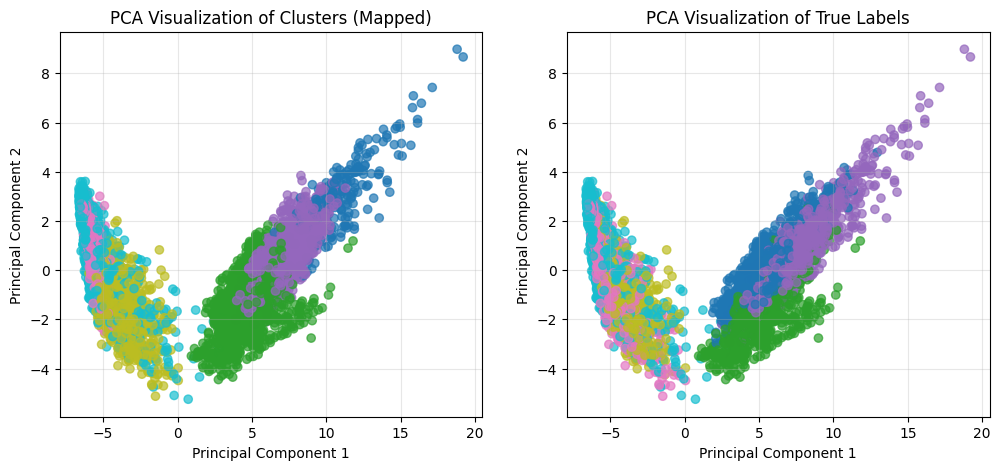

In [4]:
# 模型聚类 vs. 真实聚类
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment

# 计算混淆矩阵 (用于匹配聚类和真实标签)
contingency_matrix = confusion_matrix(y_train.iloc[:, 0], labels + 1)
# 找到最佳匹配 (匈牙利算法)
row_ind, col_ind = linear_sum_assignment(-contingency_matrix)
# 创建映射字典
mapping = {col: row for row, col in zip(row_ind, col_ind)}
# 重新映射模型的聚类标签
mapped_labels = np.array([mapping[label] for label in labels])

pca = PCA(n_components=2)
data_pca = pca.fit_transform(X_train)

# 模型聚类
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(data_pca[:, 0], data_pca[:, 1], c=mapped_labels, cmap='tab10', alpha=0.7)
axes[0].set_title("PCA Visualization of Clusters (Mapped)")
axes[0].set_xlabel("Principal Component 1")
axes[0].set_ylabel("Principal Component 2")
axes[0].grid(alpha=0.3)
# 真实聚类
axes[1].scatter(data_pca[:, 0], data_pca[:, 1], c=y_train.iloc[:, 0], cmap='tab10', alpha=0.7)

axes[1].set_title("PCA Visualization of True Labels")
axes[1].set_xlabel("Principal Component 1")
axes[1].set_ylabel("Principal Component 2")
axes[1].grid(alpha=0.3)

plt.show()

In [5]:
contingency_matrix

array([[   0,  710,  489,    0,    0,   27],
       [   0,  841,  232,    0,    0,    0],
       [   0,   62,  733,    0,    0,  191],
       [   8,    1,    0,  508,  769,    0],
       [   0,    0,    0,  687,  687,    0],
       [1403,    0,    0,    0,    4,    0]], dtype=int64)

### 5.3.2 分裂型层次聚类 (Divisive Hierarchical Clustering)

- 原理：从所有数据点作为一个簇开始，不断将簇分裂为更小的簇，直到每个数据点成为一个单独的簇。
- 优点：可根据需要选择合适的分裂策略。
- 缺点：较少用于实际应用，计算复杂度高。

In [23]:
from sklearn.cluster import KMeans
import numpy as np

def divisive_clustering(X, n_clusters):
    # 初始时所有点属于同一个簇
    clusters = [X]
    labels = np.zeros(len(X), dtype=int)
    current_label = 1

    while len(clusters) < n_clusters:
        # 找到最大簇进行分裂
        largest_cluster_idx = np.argmax([len(cluster) for cluster in clusters])
        largest_cluster = clusters.pop(largest_cluster_idx)

        # 使用 K-Means 将该簇分裂为 2 个子簇
        kmeans = KMeans(n_clusters=2, random_state=42).fit(largest_cluster)
        sub_labels = kmeans.labels_

        # 更新簇和标签
        for i in range(2):
            clusters.append(largest_cluster[sub_labels == i])
            labels[np.isin(X, largest_cluster[sub_labels == i]).all(axis=1)] = current_label
            current_label += 1

    return labels

# 执行分裂型聚类
labels = divisive_clustering(X_train, n_clusters=6)
true_labels = y_train.iloc[:, 0]
# 内在指标
print('Internal Indices')
# 紧凑度
compactness = compute_compactness(X_train, labels)
print(f'compactness:{compactness: .3f}')

# 分离度
separation = compute_separation(X_train, labels)
print(f'separation:{separation: .3f}')

# 衡量簇内点的紧密度与簇间点的分离度，取值范围：[-1, 1]，值越接近 1，说明聚类效果越好。
SC = silhouette_score(X_train, labels)  
print(f'Silhouette Coefficient:{SC: .3f}')

# 衡量簇间方差和簇内方差的比值，值越大，说明簇间分离度大，簇内紧密度高。
CH = calinski_harabasz_score(X_train, labels)  
print(f'Calinski-Harabasz Index:{CH: .3f}')

# 衡量簇间距离和簇内距离的比值，值越小，说明聚类效果越好
DB = davies_bouldin_score(X_train, labels) 
print(f'Davies-Bouldin Index:{DB: .3f}\n')


# 外在指标
print('External Indices:')
# 取值范围：[-1, 1]，值越接近 1，说明聚类结果与真实标签一致性越高。
ARI = adjusted_rand_score(true_labels, labels) 
print(f'Adjusted Rand Index:{ARI: .3f}')

#取值范围：[0, 1]，值越高说明聚类结果与真实标签一致性越高。
MI = normalized_mutual_info_score(true_labels, labels) 
print(f'Mutual Information:{MI: .3f}')

#取值范围：[0, 1]，值越高说明聚类结果与真实标签一致性越高。
FMI = fowlkes_mallows_score(true_labels, labels)
print(f'FMI:{FMI: .3f}')

c:\Users\62687\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\62687\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=29.
  warnings.warn(
c:\Users\62687\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\62687\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environm

Internal Indices
compactness: 30230.425
separation: 2.697
Silhouette Coefficient: 0.101
Calinski-Harabasz Index: 3036.367
Davies-Bouldin Index: 2.452

External Indices:
Adjusted Rand Index: 0.502
Mutual Information: 0.616
FMI: 0.587


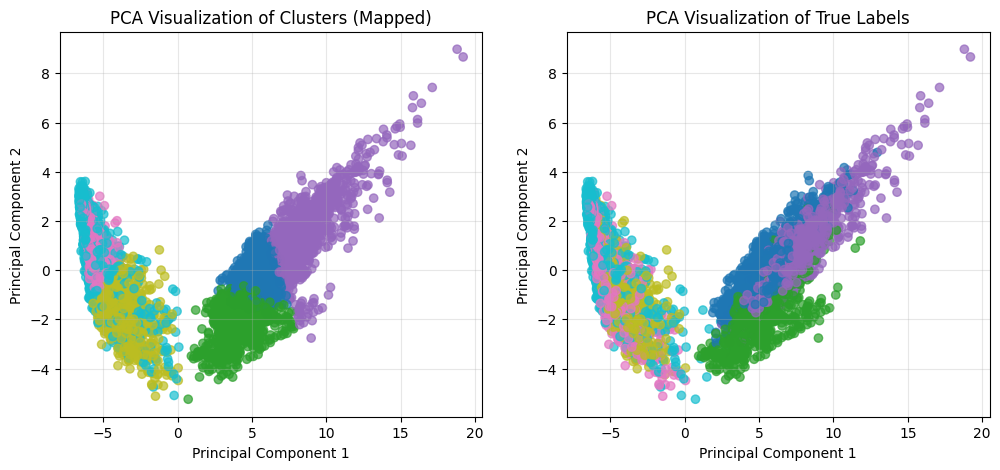

In [33]:
# 模型聚类 vs. 真实聚类
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment

# 计算混淆矩阵 (用于匹配聚类和真实标签)
mapping0 = {label: i for i, label in enumerate(set(labels))}
labels = np.array([mapping0[label] for label in labels])
contingency_matrix = confusion_matrix(y_train.iloc[:, 0], labels)
# 找到最佳匹配 (匈牙利算法)
row_ind, col_ind = linear_sum_assignment(-contingency_matrix)
# 创建映射字典
mapping = {col: row for row, col in zip(row_ind, col_ind)}
# 重新映射模型的聚类标签
mapped_labels = np.array([mapping[label] for label in labels])

pca = PCA(n_components=2)
data_pca = pca.fit_transform(X_train)

# 模型聚类
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(data_pca[:, 0], data_pca[:, 1], c=mapped_labels, cmap='tab10', alpha=0.7)
axes[0].set_title("PCA Visualization of Clusters (Mapped)")
axes[0].set_xlabel("Principal Component 1")
axes[0].set_ylabel("Principal Component 2")
axes[0].grid(alpha=0.3)
# 真实聚类
axes[1].scatter(data_pca[:, 0], data_pca[:, 1], c=y_train.iloc[:, 0], cmap='tab10', alpha=0.7)

axes[1].set_title("PCA Visualization of True Labels")
axes[1].set_xlabel("Principal Component 1")
axes[1].set_ylabel("Principal Component 2")
axes[1].grid(alpha=0.3)

plt.show()